In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -5000
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 40 #10

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 1
        
        self.learning_rate = 0.000945
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0.00001
    NEGATIVE_TIMES_REWARD = 0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 80 on candle 117
More than 80 on candle 421
More than 80 on candle 1889


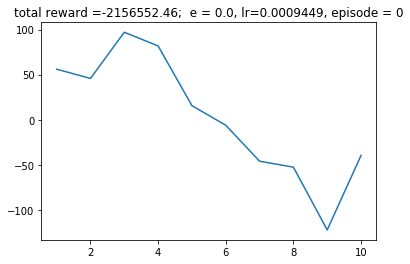

Waiting to train the whole dataset
DONE, lets roll!!
157.88
More than 80 on candle 90
More than 80 on candle 168
More than 80 on candle 290
More than 80 on candle 475
More than 80 on candle 508
More than 80 on candle 1928


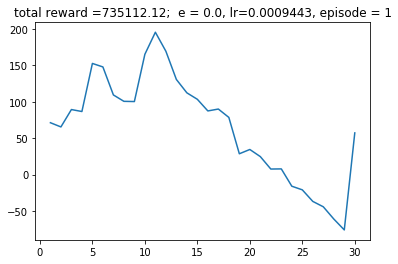

Waiting to train the whole dataset
DONE, lets roll!!
380.036
More than 80 on candle 94
More than 80 on candle 290
More than 80 on candle 474
More than 80 on candle 512
More than 80 on candle 824
More than 80 on candle 1487
More than 80 on candle 1733


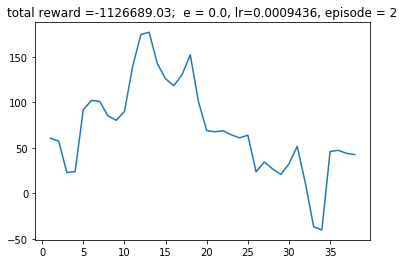

Waiting to train the whole dataset
DONE, lets roll!!
382.327
More than 80 on candle 104
More than 80 on candle 288
More than 80 on candle 482
More than 80 on candle 1489
More than 80 on candle 1737


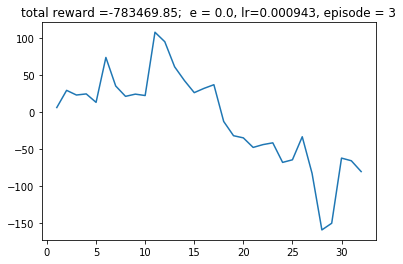

Waiting to train the whole dataset
DONE, lets roll!!
374.617
More than 80 on candle 115
More than 80 on candle 331


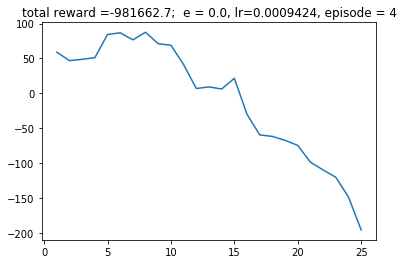

Waiting to train the whole dataset
DONE, lets roll!!
365.951
More than 80 on candle 646
More than 80 on candle 1494
More than 80 on candle 1725


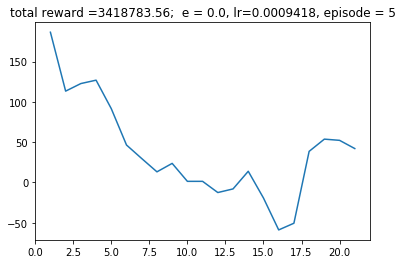

Waiting to train the whole dataset
DONE, lets roll!!
365.783
More than 80 on candle 117
More than 80 on candle 214
More than 80 on candle 346
More than 80 on candle 511
More than 80 on candle 1483
More than 80 on candle 1660
More than 80 on candle 1751


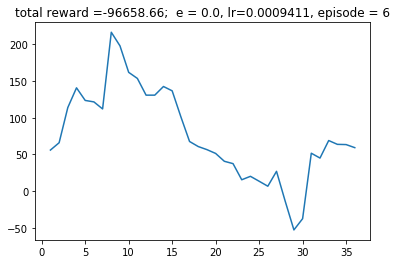

Waiting to train the whole dataset
DONE, lets roll!!
382.419
More than 80 on candle 109
More than 80 on candle 344
More than 80 on candle 506
More than 80 on candle 1488
More than 80 on candle 1617
More than 80 on candle 1723


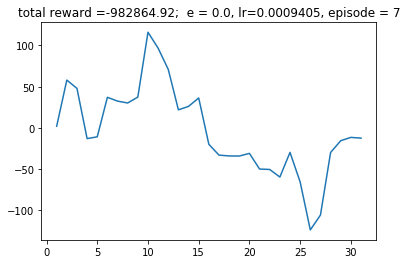

Waiting to train the whole dataset
DONE, lets roll!!
374.189
More than 80 on candle 109
More than 80 on candle 209
More than 80 on candle 344
More than 80 on candle 441
More than 80 on candle 492
More than 80 on candle 1792


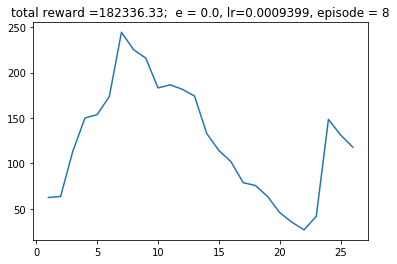

Waiting to train the whole dataset
DONE, lets roll!!
374.88
More than 80 on candle 100
More than 80 on candle 153
More than 80 on candle 270
More than 80 on candle 1874


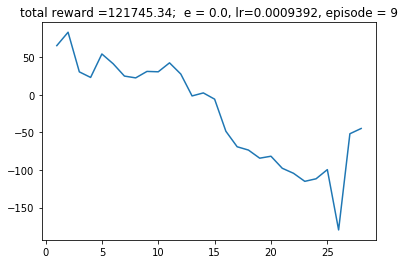

Waiting to train the whole dataset
DONE, lets roll!!
376.442
More than 80 on candle 108
More than 80 on candle 354
More than 80 on candle 1492
More than 80 on candle 1725


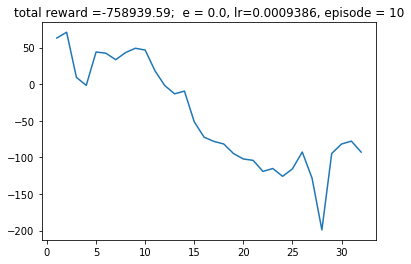

Waiting to train the whole dataset
DONE, lets roll!!
445.373
More than 80 on candle 97
More than 80 on candle 273
More than 80 on candle 486
More than 80 on candle 749
More than 80 on candle 1413
More than 80 on candle 1458
More than 80 on candle 1745


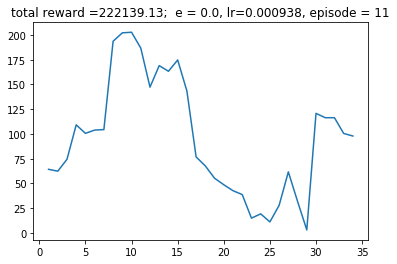

Waiting to train the whole dataset
DONE, lets roll!!
381.974
More than 80 on candle 88
More than 80 on candle 325
More than 80 on candle 366
More than 80 on candle 415
More than 80 on candle 1504
More than 80 on candle 1728


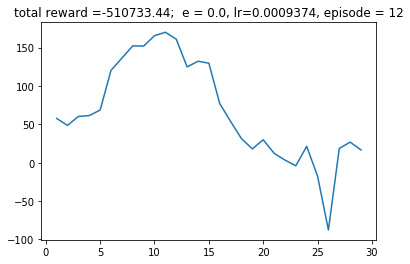

Waiting to train the whole dataset
DONE, lets roll!!
380.449
More than 80 on candle 169
More than 80 on candle 216
More than 80 on candle 337
More than 80 on candle 781
More than 80 on candle 1498
More than 80 on candle 1719


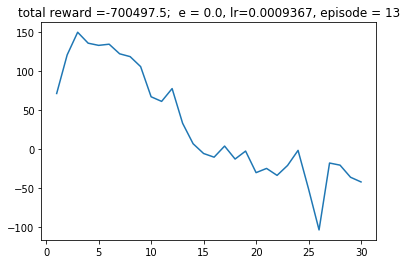

Waiting to train the whole dataset
DONE, lets roll!!
385.754
More than 80 on candle 122
More than 80 on candle 328
More than 80 on candle 484
More than 80 on candle 526
More than 80 on candle 1925


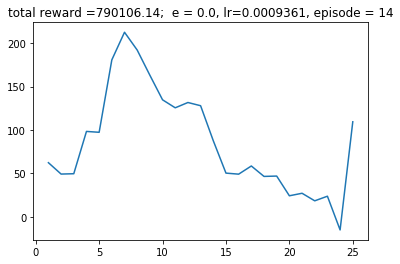

Waiting to train the whole dataset
DONE, lets roll!!
368.128
More than 80 on candle 104
More than 80 on candle 334
More than 80 on candle 493
More than 80 on candle 1492
More than 80 on candle 1740


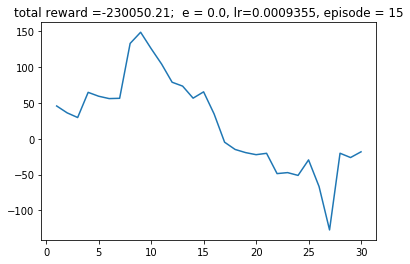

Waiting to train the whole dataset
DONE, lets roll!!
375.174
More than 80 on candle 126
More than 80 on candle 351
More than 80 on candle 562
More than 80 on candle 1926


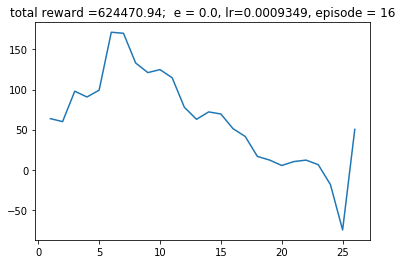

Waiting to train the whole dataset
DONE, lets roll!!
375.209
More than 80 on candle 122
More than 80 on candle 366
More than 80 on candle 430
More than 80 on candle 476
More than 80 on candle 1517
More than 80 on candle 1722


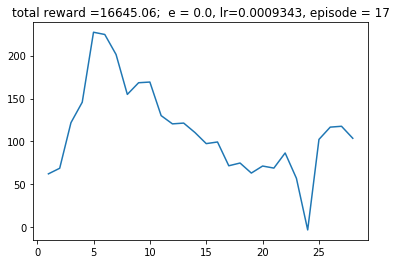

Waiting to train the whole dataset
DONE, lets roll!!
383.866
More than 80 on candle 89
More than 80 on candle 278
More than 80 on candle 538
More than 80 on candle 609
More than 80 on candle 727
More than 80 on candle 1459
More than 80 on candle 1581
More than 80 on candle 1681


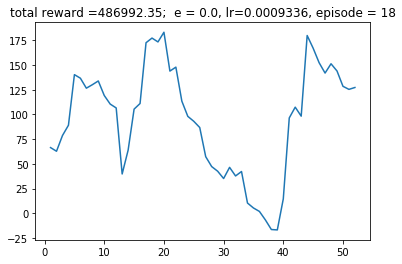

Waiting to train the whole dataset
DONE, lets roll!!
382.839
More than 80 on candle 99
More than 80 on candle 315
More than 80 on candle 375
More than 80 on candle 475
More than 80 on candle 609
More than 80 on candle 1595


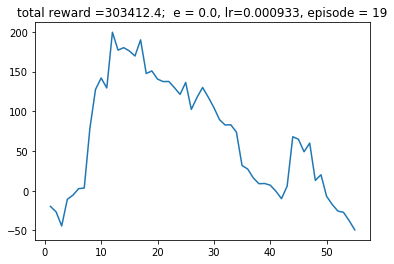

Waiting to train the whole dataset
DONE, lets roll!!
386.101
More than 80 on candle 87
More than 80 on candle 258
More than 80 on candle 319
More than 80 on candle 375
More than 80 on candle 574
More than 80 on candle 656
More than 80 on candle 734
More than 80 on candle 1743


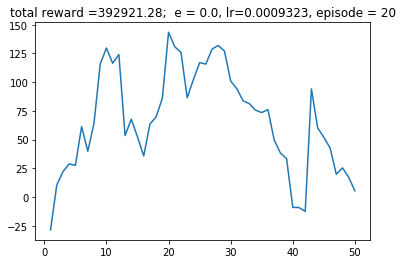

Waiting to train the whole dataset
DONE, lets roll!!
383.746
More than 80 on candle 108
More than 80 on candle 273
More than 80 on candle 360
More than 80 on candle 510
More than 80 on candle 879
More than 80 on candle 908
More than 80 on candle 955
More than 80 on candle 1748


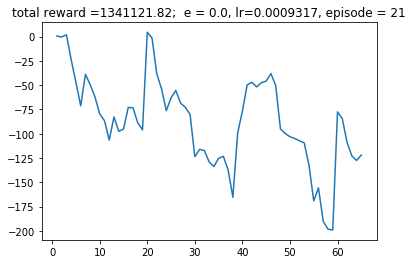

Waiting to train the whole dataset
DONE, lets roll!!
373.302
More than 80 on candle 79
More than 80 on candle 274
More than 80 on candle 446
More than 80 on candle 494
More than 80 on candle 605
More than 80 on candle 644
More than 80 on candle 717
More than 80 on candle 901
More than 80 on candle 1497
More than 80 on candle 1555
More than 80 on candle 1727


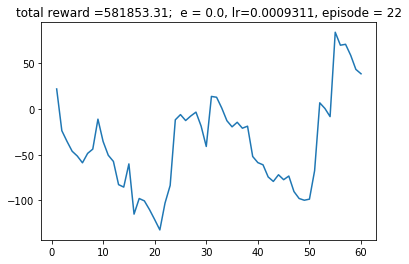

Waiting to train the whole dataset
DONE, lets roll!!
372.677
More than 80 on candle 416
More than 80 on candle 515
More than 80 on candle 916
More than 80 on candle 1582
More than 80 on candle 1715


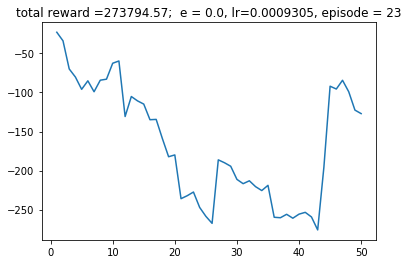

Waiting to train the whole dataset
DONE, lets roll!!
376.142
More than 80 on candle 24
More than 80 on candle 101
More than 80 on candle 166
More than 80 on candle 341
More than 80 on candle 533
More than 80 on candle 568
More than 80 on candle 898
More than 80 on candle 1495
More than 80 on candle 1555
More than 80 on candle 1616
More than 80 on candle 1700


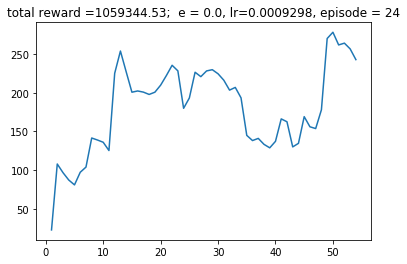

Waiting to train the whole dataset
DONE, lets roll!!
386.276
More than 80 on candle 118
More than 80 on candle 334
More than 80 on candle 600
More than 80 on candle 892
More than 80 on candle 1775


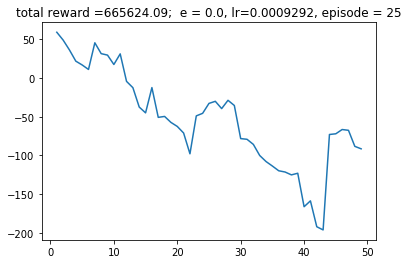

Waiting to train the whole dataset
DONE, lets roll!!
381.048
More than 80 on candle 107
More than 80 on candle 354
More than 80 on candle 475
More than 80 on candle 542
More than 80 on candle 595
More than 80 on candle 874
More than 80 on candle 1554
More than 80 on candle 1732


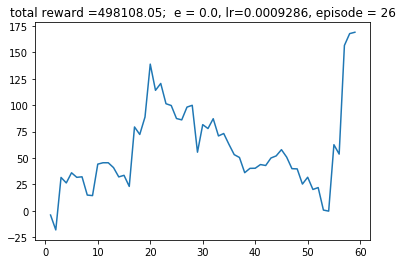

Waiting to train the whole dataset
DONE, lets roll!!
392.445
More than 80 on candle 118
More than 80 on candle 339
More than 80 on candle 510
More than 80 on candle 599
More than 80 on candle 1486
More than 80 on candle 1576
More than 80 on candle 1744


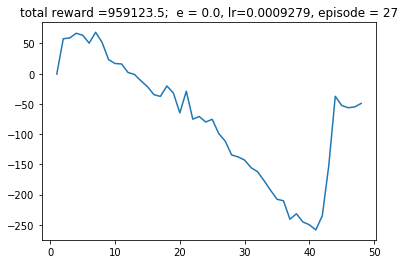

Waiting to train the whole dataset
DONE, lets roll!!
382.47
More than 80 on candle 103
More than 80 on candle 379
More than 80 on candle 488
More than 80 on candle 602
More than 80 on candle 1577
More than 80 on candle 1771


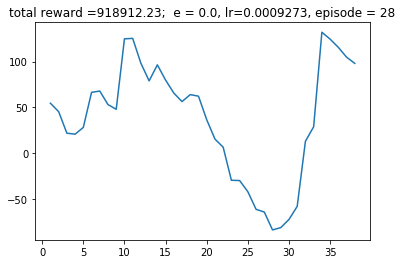

Waiting to train the whole dataset
DONE, lets roll!!
380.759
More than 80 on candle 116
More than 80 on candle 336
More than 80 on candle 489
More than 80 on candle 604
More than 80 on candle 952
More than 80 on candle 1573
More than 80 on candle 1739


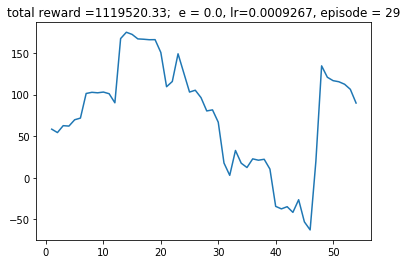

Waiting to train the whole dataset
DONE, lets roll!!
381.592
More than 80 on candle 365
More than 80 on candle 549
More than 80 on candle 659
More than 80 on candle 1492
More than 80 on candle 1588
More than 80 on candle 1737


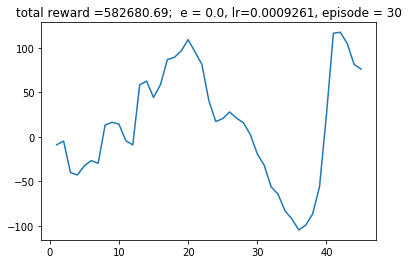

Waiting to train the whole dataset
DONE, lets roll!!
372.83
More than 80 on candle 97
More than 80 on candle 333
More than 80 on candle 492
More than 80 on candle 570
More than 80 on candle 900
More than 80 on candle 1482
More than 80 on candle 1604
More than 80 on candle 1769


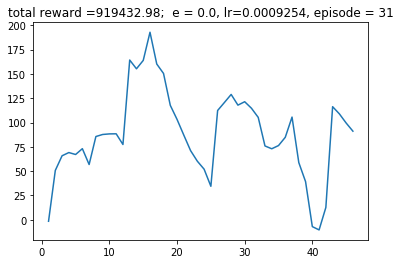

Waiting to train the whole dataset
DONE, lets roll!!
384.901
More than 80 on candle 86
More than 80 on candle 271
More than 80 on candle 475
More than 80 on candle 517
More than 80 on candle 607
More than 80 on candle 903
More than 80 on candle 1498
More than 80 on candle 1577
More than 80 on candle 1771


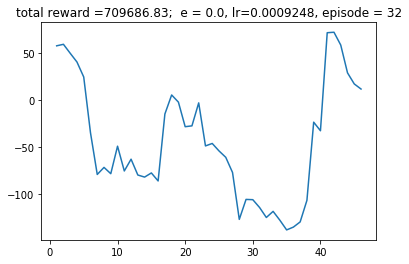

Waiting to train the whole dataset
DONE, lets roll!!
369.418
More than 80 on candle 87
More than 80 on candle 274
More than 80 on candle 355
More than 80 on candle 512
More than 80 on candle 573
More than 80 on candle 904
More than 80 on candle 969
More than 80 on candle 1492
More than 80 on candle 1580
More than 80 on candle 1733
More than 80 on candle 1777


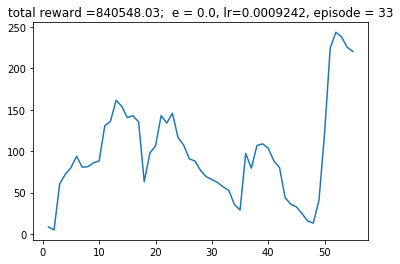

Waiting to train the whole dataset
DONE, lets roll!!
388.331
More than 80 on candle 124
More than 80 on candle 330


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))